1. 데이터 살펴보기
2. 데이터셋 만들기
3. 모델 정의하기
- Low 레벨 특징 추출모델
- Middle 레벨 특징 추출모델
- Global 레벨 특징 추출모델
- 컬러라이제이션
- 전체 모델

4. 모델 학습하기
5. 성능 평가하기

# 데이터 살펴보기

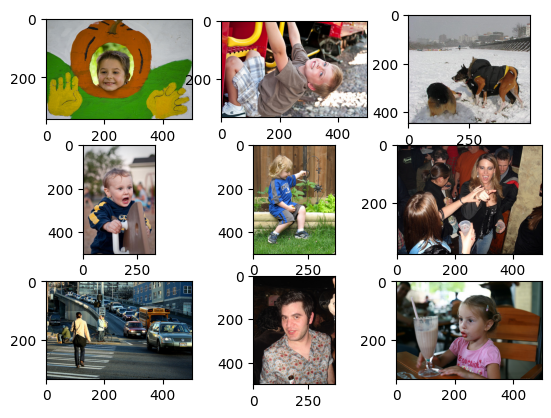

In [3]:
import glob
import matplotlib.pyplot as plt

from PIL import Image

imgs = glob.glob("/content/drive/MyDrive/2023_딥러닝/ch09_자동채색/Flickr8k_Dataset/*.jpg")

# 이미지 9개를 표기
for i in range(9):
   img = Image.open(imgs[i])
   plt.subplot(3, 3, i+1)
   plt.imshow(img)
plt.show()

# 학습용 데이터셋

In [4]:
import cv2
import numpy as np

from torch.utils.data.dataset import Dataset

def rgb2lab(rgb):
  # RGB 이미지를 입력받은 뒤 RGB를 LAB로 변환
  # cvtColor(A, B) : A이미지를 B형식으로 변환
   return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

def lab2rgb(lab):
  # LAB 이미지를 입력받은 뒤 LAB를 RGB로 변환
   return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

학습용 데이터셋 정의

In [5]:
class AutoColoring(Dataset):
   def __init__(self):  # ❶ 데이터셋의 초기화 함수
       self.data = glob.glob("/content/drive/MyDrive/2023_딥러닝/ch09_자동채색/Flickr8k_Dataset/*.jpg")

   def __len__(self):   # ❷ 사용 가능한 데이터의 개수를 반환하는 함수
       return len(self.data)

   def __getitem__(self, i): # ❸ 데이터를 호출하는 함수
       # RGB 이미지를 불러옴
       rgb = np.array(Image.open(self.data[i]).resize((256, 256)))
       # LAB로 변환
       lab = rgb2lab(rgb)

    #채널 차원이 가장 앞에 오도록 변경
    # Q : 왜 차원이 가장 앞에 와야하는가/
    # A : 입력이기 때문에??+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


       # 파이토치는 채널이 가장 앞에 와야 하므로 transpose
       lab = lab.transpose((2, 0, 1)).astype(np.float32)
       # 흑백 이미지가 들어가므로 L채널이 입력, 색을표현하는 AB채널이 정답이 된다
       return lab[0], lab[1:]

# 3. 모델 정의하기

Low 레벨 특징 추출기

- 보통 합성곱, 배치정규화, 활성화층 순서로 설계함

low 레벨의 특징 추출기의 순전파 구현
- 합성곱, 배치 정규화, 시그모이드

In [6]:
import torch
import torch.nn as nn


class LowLevel(nn.Module):
   def __init__(self):
       # Low 레벨 특징 추출기를 구성하는 층의 정의
       super(LowLevel, self).__init__()

       self.low1 = nn.Conv2d(1, 64,
                             kernel_size=3, stride=2, padding=1)
       self.lb1 = nn.BatchNorm2d(64)

       self.low2 = nn.Conv2d(64, 128,
                             kernel_size=3, stride=1, padding=1)
       self.lb2 = nn.BatchNorm2d(128)

      # 흔히 conv에서 사용하는 pooling 대신 stride를 증가시키는 기법을 사용
       self.low3 = nn.Conv2d(128, 128,
                             kernel_size=3, stride=2, padding=1)
       self.lb3 = nn.BatchNorm2d(128)
       self.low4 = nn.Conv2d(128, 256,
                             kernel_size=3, stride=1, padding=1)
       self.lb4 = nn.BatchNorm2d(256)
       self.low5 = nn.Conv2d(256, 256,
                             kernel_size=3, stride=2, padding=1)
       self.lb5 = nn.BatchNorm2d(256)
       self.low6 = nn.Conv2d(256, 512,
                             kernel_size=3, stride=1, padding=1)
       self.lb6 = nn.BatchNorm2d(512)

       self.sigmoid = nn.Sigmoid()

   def forward(self, x):
       low = self.low1(x)        # 합성곱
       low = self.lb1(low)       # 배치 정규화
       low = self.sigmoid(low)   # 시그모이드

       low = self.low2(low)
       low = self.lb2(low)
       low = self.sigmoid(low)

       low = self.low3(low)
       low = self.lb3(low)
       low = self.sigmoid(low)

       low = self.low4(low)
       low = self.lb4(low)
       low = self.sigmoid(low)

       low = self.low5(low)
       low = self.lb5(low)
       low = self.sigmoid(low)

       low = self.low6(low)
       low = self.lb6(low)
       low = self.sigmoid(low)

       return low

Middle 레벨 특징 추출모델
- 이미지 크기가 변하면 안됨
- 합성곱 커널의 크기가 3일 때, 스트라이드와 패딩을 모두 1로 설정
- 본문에서는 기본 블록을 2번 반복함
- low 레벨에서 이미지 크기를 많이 줄였기 때문에 middle 레벨을 많이 반복할 필요가 없다고 함

In [7]:
class MidLevel(nn.Module):
   def __init__(self):
       super(MidLevel, self).__init__()

       self.mid1 = nn.Conv2d(512, 512,
                             kernel_size=3, stride=1, padding=1)
       self.mb1 = nn.BatchNorm2d(512)
       self.mid2 = nn.Conv2d(512, 256,
                             kernel_size=3, stride=1, padding=1)
       self.mb2 = nn.BatchNorm2d(256)

       self.sigmoid = nn.Sigmoid()

   def forward(self, x):
       mid = self.mid1(x)       # 합성곱
       mid = self.mb1(mid)      # 배치 정규화
       mid = self.sigmoid(mid)  # 시그모이드

       mid = self.mid2(mid)
       mid = self.mb2(mid)
       mid = self.sigmoid(mid)

       return mid

Global 레벨 특징추출 모델
- 기본블록(4회) -> 평탄화 -> MLP층

- low, mid와 기본 블록 구성은 동일
- 마지막에  MLP층으로 입력할 수 있도록 1차원으로 변환해줌
- 기본 블록을 4번 반복

In [8]:
class GlobalLevel(nn.Module):
   def __init__(self):
       super(GlobalLevel, self).__init__()

       self.glob1 = nn.Conv2d(512, 512,
                              kernel_size=3, stride=2, padding=1)
       self.gb1 = nn.BatchNorm2d(512)
       self.glob2 = nn.Conv2d(512, 512,
                              kernel_size=3, stride=1, padding=1)
       self.gb2 = nn.BatchNorm2d(512)
       self.glob3 = nn.Conv2d(512, 512,
                              kernel_size=3, stride=2, padding=1)
       self.gb3 = nn.BatchNorm2d(512)
       self.glob4 = nn.Conv2d(512, 512,
                              kernel_size=3, stride=1, padding=1)
       self.gb4 = nn.BatchNorm2d(512)

    # 글로벌 레벨 특징 추출기의MLP층 구성
    # 여기서는 분류기로 사용되는 것이아닌 색을 칠하기 위해 사용하는 특징으로 사용

       self.fc1 = nn.Linear(in_features=32768, out_features=1024)
       self.fc2 = nn.Linear(in_features=1024, out_features=512)
       self.fc3 = nn.Linear(in_features=512, out_features=256)

       self.sigmoid = nn.Sigmoid()

    # forward 구성
   def forward(self, x):
       glo = self.glob1(x)      # 합성곱
       glo = self.gb1(glo)      # 배치 정규화
       glo = self.sigmoid(glo)  # 활성화

       glo = self.glob2(glo)
       glo = self.gb2(glo)
       glo = self.sigmoid(glo)

       glo = self.glob3(glo)
       glo = self.gb3(glo)
       glo = self.sigmoid(glo)

       glo = self.glob4(glo)
       glo = self.gb4(glo)
       glo = self.sigmoid(glo)

    # 추출된 특징을 flatten 매서드를 이용해서 1차원으로 평탄화
       glo = torch.flatten(glo, start_dim=1)

    # MLP층을 거쳐서 추후 미들레벨 특징 추출기의 출력과 합쳐짐

       glo = self.fc1(glo)
       glo = self.sigmoid(glo)
       glo = self.fc2(glo)
       glo = self.sigmoid(glo)
       glo = self.fc3(glo)
       glo = self.sigmoid(glo)

       return glo

컬러라이제이션 신경망
- 추출된 특징을 이용해 색을 칠하는 신경망
- 인/디코더의 디코더처럼 업샘플링층과 배치정규화층을 차례로 거치는 구조
- 추출모델과 비슷하나 합성곱이 아닌 업생플링을 활용함 (4회)
- 마지막 업샘플링층은 픽셀값을 직접 나타내기 위해서 배치정규화는 사용하지 않음

In [9]:
class Colorization(nn.Module):
  def __init__(self):
    super(Colorization, self).__init__()

    # 업샘플링 커널 3, 스트라이드 1, 패딩 1
    self.color1 = nn.ConvTranspose2d(256, 128, 3, 1, 1)
    self.cb1 = nn.BatchNorm2d(128)

    # 업샘플링 커널 2, 스트라이드 2, 패딩 0
    self.color2 = nn.ConvTranspose2d(128, 64, 2, 2)
    self.cb2 = nn.BatchNorm2d(64)

    self.color3 = nn.ConvTranspose2d(64, 64, 3, 1, 1)
    self.cb3 = nn.BatchNorm2d(64)

    self.color4 = nn.ConvTranspose2d(64, 32, 2, 2)
    self.cb4 = nn.BatchNorm2d(32)

    self.color5 = nn.ConvTranspose2d( 32, 2, 2, 2)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    color = self.color1(x)
    color = self.cb1(color)
    color = self.sigmoid(color)

    color = self.color2(color)
    color = self.cb2(color)
    color = self.sigmoid(color)

    color = self.color3(color)
    color = self.cb3(color)
    color = self.sigmoid(color)

    color = self.color4(color)
    color = self.cb4(color)
    color = self.sigmoid(color)

    color = self.color5(color)

    return color

전체 통합모델

In [10]:
# 자동채색모델 정의

class AutoColoringModel(nn.Module):
  def __init__(self):
    super(AutoColoringModel, self).__init__()

    self.low = LowLevel()
    self.mid = MidLevel()
    self.glob = GlobalLevel()

    # 특징합치기
    self.fusion = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)

    # 색입히기
    self.color = Colorization()
    # 활성화함수
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    low = self.low(x)

    # mid 레벨 추출모델에 low 레벨 추출모델의 출력을 넣어줌
    mid = self.mid(low)
    glo = self.glob(low)

    # 글로벌 레벨 특징 추출모델의 출력을 mid 모델의 출력크기가 되도록 반복
    # repeeat(dim) : 텐서를 dim차원반큼 반복실행함
    fusion = glo.repeat(1,mid.shape[2]*mid.shape[2])
    fusion = torch.reshape(fusion, (-1, 256, mid.shape[2], mid.shape[2]))

    # 미들 모델과 글로벌 모델에서 각가 추출된 특징을 결합
    # cat([A,B], dim) : 리스트의 텐서들을 dim 방향으로 합쳐줌
    fusion = torch.cat([mid, fusion], dim=1)
    fusion = self.fusion(fusion)
    fusion = self.sigmoid(fusion)

    # 컬러라리제이션 신경망을 통해서 색을 복
    color = self.color(fusion)

    return color

# 모델 학습하기

In [11]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoColoringModel().to(device)

dataset = AutoColoring()
print(len(dataset))
loader = DataLoader(dataset, batch_size=32, shuffle = True)
optim = Adam(params=model.parameters(),lr=0.01)

for epoch in range(10):
  iterator = tqdm.tqdm(loader)
  for L, AB in iterator:
    L = torch.unsqueeze(L, dim=1).to(device)
    optim.zero_grad()
    pred = model(L)

    loss = nn.MSELoss()(pred, AB.to(device))
    loss.backward()
    optim.step()

    iterator.set_description(f"epoch:{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "AutoColor.pth")

8091


epoch:9 loss:299.123046875: 100%|██████████| 253/253 [03:16<00:00,  1.29it/s]


# 성능 평가하기

In [16]:
for i in range(10):
  # ➊결과 비교를 위한 실제 이미지
  # pyplot의 이미지 형식에 맞추기 위한 약간의 변형이 필요함
  test_L, test_AB = dataset[i]
  test_L = np.expand_dims(test_L, axis=0)
  real_img = np.concatenate([test_L, test_AB])
  real_img = real_img.transpose(1, 2, 0).astype(np.uint8)
  real_img = lab2rgb(real_img)

  # 모델이 예측한 결과
  with torch.no_grad():
    # 모델 가중치 불러오기
    model.load_state_dict(
        torch.load("AutoColor.pth", map_location=device))

    # ➋모델의 예측값 계산
    input_tensor = torch.tensor(test_L)
    input_tensor = torch.unsqueeze(input_tensor, dim=0).to(device)
    pred_AB = model(input_tensor)

    # ➌pyplot의 이미지 형식에 맞추기 위한 약간의 변형이 필요함
    pred_LAB = torch.cat([input_tensor, pred_AB], dim=1)
    pred_LAB = torch.squeeze(pred_LAB)
    pred_LAB = pred_LAB.permute(1, 2, 0).cpu().numpy()
    pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

  # ➍실제와 예측값의 비교
  plt.subplot(1, 2, 1)
  plt.imshow(real_img)
  plt.title("real image")
  plt.subplot(1, 2, 2)
  plt.imshow(pred_LAB)
  plt.title("predicted image")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.